# Final Project

Our idea is find out what the Public opinion is on Twitter on the overturning of Roe v. Wade in large city’s in the US  and to investigate whether it corresponds with the laws in that state.

### Retrieving and storing Twitter data

First, we will import the Tweepy API, which we can use to retrieve tweets. We applied for Academic Research access, so we could retrieve more t to search for tweets around the time Roe V Wade overturned and to check the location of the tweet.

In [278]:
import tweepy

CONSUMER_KEY = 'pttmAvuj8z26khmI29Iy6Yvkt'
CONSUMER_SECRET = 'AxWg9dcVVFX1K9TrLUiecXBqpSZn4lu1qEJvIlAoWRRUDd9F9x'
OAUTH_TOKEN = '1364492577957965825-3Curg3S5QShUpIa3YcF7VpHJTGzSkT'
OAUTH_TOKEN_SECRET = 'md1dtliBClGRem1MDUpLMoCm4GtKXbkMsx54sZAeDpRNU'
bearer_token = 'AAAAAAAAAAAAAAAAAAAAAN29jwEAAAAA83MuicQ7VEXm9VY%2F68ZZ%2BGVht9I%3DAkULEZI8WPV44znUF6pVf0D8MHazsz2xh8jsq2I5UH9PCPxds7'

client = tweepy.Client(bearer_token)

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

api = tweepy.API(auth, wait_on_rate_limit=True)

We created a function to add new lines to files. We will create two files, one containing the tweets and the second containing the location.

In [279]:
def append_new_line(file_name, text_to_append):
    with open(file_name, "a+") as file_object:
        file_object.seek(0)
        data = file_object.read(100)
        if len(data) > 0:
            file_object.write("\n")
        file_object.write(text_to_append)

Here we specify the query, we want to find tweets containing the hashtag #RoeVwade. Furthermore we specify that the tweet is not a retweet and the country where the tweet has been posted is in the US. The timeframe we collect tweets is 5 days before Roe V. Wade overturned and five days after. Since there is a limit of tweets you can collect, we store the tweets and locations immeditately in a file. We included a sleep time to make sure we would not receive a too many request error. 

We can skip this code if we collected all tweets and locations in the files

In [280]:
#import time
#query = '#RoeVWade -is:retweet place_country:US'

#start_time = '2022-06-19T00:00:00Z'
#end_time = '2022-06-29T00:00:00Z'

#limit is 100
#for i in range(1500):
    #max_result=100

    #tweets = client.search_all_tweets(query=query, tweet_fields=['context_annotations', 'created_at', 'geo'],
    #                                  place_fields=['place_type', 'geo'], expansions='geo.place_id', 
    #                                  start_time=start_time, end_time=end_time, max_results=max_result)

    # Get list of places from includes object
    #places = {p["id"]: p for p in tweets.includes['places']}

    #for tweet in tweets.data:
        #text = tweet.text
        #if places[tweet.geo['place_id']]:
            #place = places[tweet.geo['place_id']]
            #place = place.full_name
        #text_to_append = (text + ': ' + place)
        #append_new_line('tweets.txt', text)
        #append_new_line('locations.txt', place)
    #time.sleep(2)

Here we merge the two files into one dataframe consisting of a column of tweets and a column with locations.

In [281]:
df1 = pd.read_csv('tweets.txt', sep='\t', header=None, names=['Tweet'])
df2 = pd.read_csv('locations.txt', sep='\t', header=None, names=['Location'])


df = pd.concat([df1, df2], axis=1, join='inner')
print(len(df))
display(df.head(5))


150000


,Tweet,Location
0,Democratic senators need to shut up and come u...,"Wisconsin, USA"
1,Overturning #RoeVWade is a public health crisi...,"Cleveland, OH"
2,SIGN NOW -&gt; Demand Congress stand up immedi...,"Delaware, USA"
3,#RoeVWade https://t.co/VYMtMZVuHH,"Evendale, OH"
4,This days it all. #RoeVWade https://t.co/JvMFK...,"Lea Hill, WA"


### Clean Location

We retrieve the location from the tweets metadata, however, it is not always in the form we want. Overall the form is 'city', 'state abbreviation'. Lets start with splitting the location values into two columns. 

We focus on the second column, containing the state abbreviation. When looking at the unique values from that column below, we see that some values do not have the state abbreviation, but instead USA or None. Before continuing with our project we would like to clean this. In the end we want one column with only the state abbrevation.

In [282]:
df[['First','Last']] = df.Location.str.split(",",expand=True,)
df['Last'] = df['Last'].str.strip()

In [283]:
print(df.Last.unique())

['USA' 'OH' 'WA' 'MO' 'MN' 'GA' 'NY' 'CO' 'NV' 'MS' 'MI' None 'IN' 'LA'
 'TX' 'OR' 'DC' 'CA' 'NE' 'IA' 'SC' 'PA' 'MA' 'Philadelphia' 'NC' 'TN'
 'FL' 'Puerto Rico' 'HI' 'OK' 'AL' 'NJ']


We replace Philadelphia with the state it belongs to and we remove Puerto Rico.

In [284]:
import numpy as np

#Puerto Rico is part of the USA, but for simplicity we only use the states. 
df.drop(df.loc[df['Last']=='Puerto Rico'].index, inplace=True)

#We change philadelphia into the state it belongs to
df.loc[df["Last"] == 'Philadelphia', "Last"] = 'PA'

Some rows contain the value USA instead of the state abbreviation. Lets see what is in the first column when this happens. Below we see it happens for wisconsin, delaware, new york, colorado, kansas, florida, indiana and maine. These are all states, so we will loop through the rows and replace USA with the correct state abbreviation.

In [285]:
df2=df.loc[df['Last'] == 'USA', 'First']
df2.unique()

array(['Wisconsin', 'Delaware', 'New York', 'Colorado', 'Kansas',
       'Florida', 'Indiana', 'Maine'], dtype=object)

In [286]:
state_to_abbrev = {
    "Wisconsin": "WI",
    "Delaware": "DE",
    "New York": "NY",
    "Colorado": "CO",
    "Kansas": "KS",
    "Florida": "FL",
    "Indiana": "IN",
    "Maine": "ME"}


for i, row in df.iterrows():
    if row.Last == 'USA':
        df.at[i, 'Last'] = state_to_abbrev[row.First]

df.head(5)

,Tweet,Location,First,Last
0,Democratic senators need to shut up and come u...,"Wisconsin, USA",Wisconsin,WI
1,Overturning #RoeVWade is a public health crisi...,"Cleveland, OH",Cleveland,OH
2,SIGN NOW -&gt; Demand Congress stand up immedi...,"Delaware, USA",Delaware,DE
3,#RoeVWade https://t.co/VYMtMZVuHH,"Evendale, OH",Evendale,OH
4,This days it all. #RoeVWade https://t.co/JvMFK...,"Lea Hill, WA",Lea Hill,WA


Now we focus on the None column, lets check what is in the first column when this happens. Below we see it happens for specific places, and the fast food place McDonald's.

In [287]:
df2=df.loc[df['Last'].isna(), 'First']
df2.unique()

array(['Downtown Springfield', 'Washington Square Park',
       'Fountains of Bellagio', "McDonald's"], dtype=object)

In [288]:
clean_dict = {
    "Downtown Springfield": "MO",
    "Washington Square Park": "NY",
    "Fountains of Bellagio": "NV"}

for i, row in df.iterrows():
    value = row['Last']
    if pd.isnull(value) and row.First != "McDonald's":
        df.at[i, 'Last'] = clean_dict[row.First]
    if pd.isnull(value) and row.First == "McDonald's":
        df.drop(i, inplace=True)


Lets see how many rows we have left. Wow a lot of the tweets were located in Mcdonalds. I wonder why the Mcdonalds is stored in the metadata instead of the actual location.

In [289]:
print(len(df))

146940


In [292]:
final_df = df[['Tweet', 'Last']].copy()
final_df.rename(columns={'Last':'Location'}, inplace=True)

final_df.head(5)

,Tweet,Location
0,Democratic senators need to shut up and come u...,WI
1,Overturning #RoeVWade is a public health crisi...,OH
2,SIGN NOW -&gt; Demand Congress stand up immedi...,DE
3,#RoeVWade https://t.co/VYMtMZVuHH,OH
4,This days it all. #RoeVWade https://t.co/JvMFK...,WA


# TO DO

- i think it is interesting to investigate the spread of the location of the tweets, thus how many tweets per state. I stored the state as the abbreviation, but we could also store it as the whole name if that is easier, idk. Maybe make a nice graph. Something like this (https://www.geo-social.com/blogs/Jonathan_poster_2022.pdf) here they use colors to represent each state in a map, we could also do this for the spread of the tweets (and later also for the sentiment)

- below we have some code for cleaning the twitter data and making the wordcloud, i did not test this yet with the new dataframe, so maybe some things need to be changed. And it would be interesting to compare some of the states (maybe the ones with the most tweets) and see if the wordclouds look a like

- after cleaning the tweets we could start measuring the sentiment of the tweets per state. 

### Investigate spread of the tweets

### Cleaning Twitter data

To clean the twitter data we perform multiple steps. We remove links from the tweets, we remove punctuation, tokenize the tweet and remove stopwords.

In [6]:
import string
import nltk
stopword = nltk.corpus.stopwords.words('english')

def remove_link(tweet):
    tweet = re.sub(r"http\S+", "", tweet)
    return tweet

def remove_punct(tweet):
    tweet  = "".join([char for char in tweet if char not in string.punctuation])
    tweet = re.sub('[0-9]+', '', tweet)
    return tweet

def tokenization(tweet):
    tweet = re.split('\W+', tweet)
    return tweet

def remove_stopwords(tweet):
    tweet = [word for word in tweet if word not in stopword]
    return tweet

In [7]:
import re
cleaned_tweets = []
for tweet in twitter_data[:5]:
    tweet = remove_stopwords(tokenization(remove_punct(remove_link(tweet.lower()))))
    tweet = list(filter(None, tweet))
    cleaned_tweets.append(tweet)

cleaned_tweets[:1]

[['star', 'man', 'saka', 'worldcup', 'england', 'iran', 'saka']]

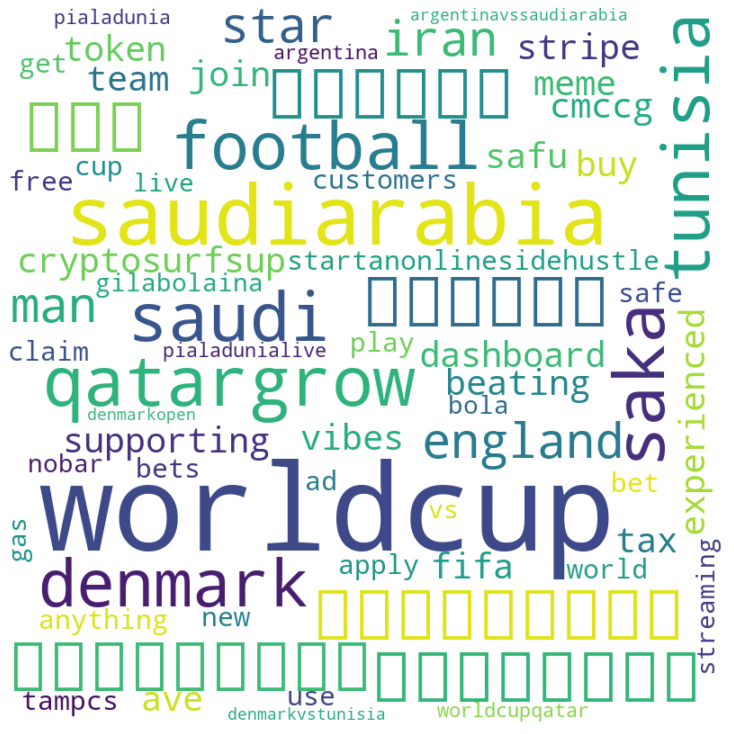

In [10]:
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

total = Counter()
for i in cleaned_tweets[0:]:
        total.update(i)
        

dict(total)
 
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(total)
  
# plot the WordCloud image
plt.figure(figsize = (15, 10), facecolor = None) 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()